In [46]:
!pip install -q -r requirements.txt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict, load_dataset, Features, Value

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
from tqdm.notebook import tqdm
import evaluate
import numpy as np
from torch.nn import functional as F
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd
from collections import Counter
from dataset_class import *
from text_clean import *
from BertDataSet import *
from utils import *
sns.set_style('whitegrid')

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

violet = '#702b9d'
RANDOM_SEED = 1011

You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

##### loading
---

In [4]:
train_path = '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_training'
val_path =  '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_validation'
training_file_path = os.path.join(train_path, 'train.csv')
validation_file_path = os.path.join(val_path, 'validation_data.csv')

###### **training**

In [5]:
toxicity_train = pd.read_csv(f'{training_file_path}')
toxicity_train['label'] = np.where(toxicity_train.target > 0.5, 1, 0)

count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='Count'>

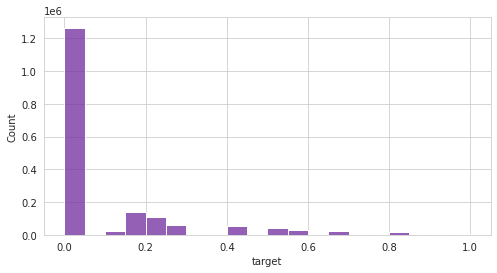

In [6]:
# take a look at distribution
print(toxicity_train.target.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.target, binwidth = .05, color = violet, ax = ax)

###### **validation**

In [7]:
toxicity_valid = pd.read_csv(f'{validation_file_path}')
print(toxicity_valid.nunique())
print(toxicity_valid.shape)

worker          753
less_toxic    11532
more_toxic    11678
dtype: int64
(30108, 3)


In [8]:
## preprocess validation dataset 
texts = set(toxicity_valid.less_toxic.to_list() + toxicity_valid.more_toxic.to_list())
text2id = {t:id for id,t in enumerate(texts)}
toxicity_valid['less_id'] = toxicity_valid['less_toxic'].map(text2id)
toxicity_valid['more_id'] = toxicity_valid['more_toxic'].map(text2id)
toxicity_valid_grouped = (toxicity_valid.groupby(['less_id', 'more_id']).first()\
                          .reset_index().drop(['less_id', 'more_id'], axis = 1).drop(['worker'], axis = 1))
toxicity_valid_grouped.rename(columns = {'less_toxic':'less_toxic_text', 'more_toxic':'more_toxic_text'}, inplace = True)

In [9]:
toxicity_valid_grouped.to_csv(f'{val_path}/validation_grouped.csv')
toxicity_valid_grouped

,less_toxic_text,more_toxic_text
0,Deletion!?!??!?\n\nWhy the hell would Calton p...,CKCKCKCK\nYo i see u tryin 2 change shit wit C...
1,Deletion!?!??!?\n\nWhy the hell would Calton p...,What did I do that was vandalism first of all ...
2,on how crap you talk,u got a problem? commie
3,You are just Jealous \n\nthat you aren't a pa...,Todo speedy deletion candidates \n\nI do not ...
4,You are just Jealous \n\nthat you aren't a pa...,"""ee\nI agree, but there are enough editors thi..."
...,...,...
15405,"Hey, that's a good tactic: calling everyone wi...",Sexism \n\nI've tried my hardest to explain t...
15406,"""\n\nStrider (novel) by Beverly Clearly. Peo...",We are Wikipedia. We will assimilate you. If w...
15407,"""\n\nStrider (novel) by Beverly Clearly. Peo...","Allah... \n\nAllah, a Muslims version of Sant..."
15408,"And I GAVE you people sources, and that still ...",I'll go back to the Dutch Wiki - mwaaaaaaaahah...


In [8]:
## make new dataframe
toxic = toxic_dataset(df = toxicity_train, text = toxicity_train.comment_text, 
                      toxicity = toxicity_train.target, size = int(1e5), label = toxicity_train.label, seed = 1011)

toxic.make_dataframe(down_sample = True, make_pairs = True, threshold = 0.01)

toxicity_train_paired = toxic.df
toxicity_train_paired.to_csv(f'{train_path}/train_paired.csv')
toxic.df

paired up ...
made new dataframe ...


,more_toxic_text,less_toxic_text,toxicity_more_toxic,toxicity_less_toxic,labels_more_toxic,labels_less_toxic
0,To enjoy frustration and helplessness of Obama...,Well the issues of gender oppression & forced ...,0.166667,0.100000,0,0
1,"""Trudeau Liberals' national climate deal to ha...","The ""stoners"" don't really care, since they ca...",0.800000,0.200000,1,0
2,"Actually, Carl, Hillary's crimes, lies and soc...",If you are doing business in a public forum an...,0.300000,0.166667,0,0
3,"Liberals are stupid, unskilled immigrants are ...",Most Catholics have no alternative to the Novu...,0.883333,0.200000,1,0
4,"As usual, Trump is right on.\n\nThink about it...",There's a couple of pretty big differences; an...,0.200000,0.111111,0,0
...,...,...,...,...,...,...
99995,Having recently returned from a few of the so-...,"@Bob Hawley and @Connie S,\n\nThe apparently d...",0.166667,0.000000,0,0
99996,"So nothing concrete to protest, they just do n...",And Obama appointed his basketball buddy. We s...,0.166667,0.166667,0,0
99997,"Stand behind your President guys, that is how ...","To continue, Walter, you write:\n\n""In regard ...",0.500000,0.166667,0,0
99998,I saw it on the news the night BEFORE his spee...,"Of course he isn't Mariota, but he's not Jonse...",0.166667,0.166667,0,0


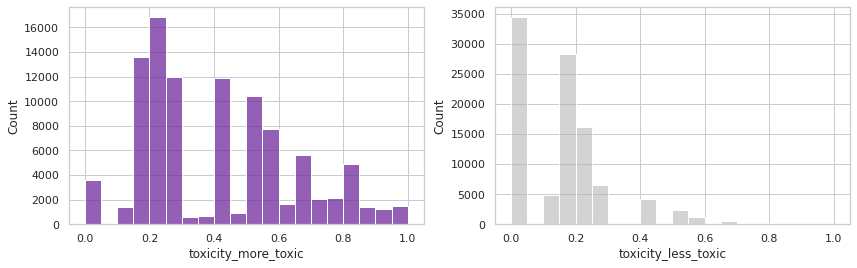

In [9]:
# take a look at distribution
fontsize = 12
fig, ax = plt.subplots(1,2, figsize = (14,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train_paired.toxicity_more_toxic, binwidth = .05, 
             color = violet, ax = ax[0], label = 'more toxic')
sns.histplot(toxicity_train_paired.toxicity_less_toxic, binwidth = .05, 
             color = 'darkgray', alpha = 0.5, ax = ax[1], label = 'less toxic')
fig.savefig(f'{os.getcwd()}/output/paired_toxicity_dist.png', bbox_inches = 'tight', dpi = 300)

##### Text cleaning (optional)
---

In [26]:
## probably should be parallelized on GPU 
toxic.df.more_toxic_text = toxic.df.more_toxic_text.map(text_cleaning)
toxic.df.less_toxic_text = toxic.df.less_toxic_text.map(text_cleaning)

In [ ]:
toxic.df.to_json(f'{train_path}/train_paired_cleaned.json')
toxic.df

In [ ]:
toxicity_valid_grouped.less_toxic_text = toxicity_valid_grouped.less_toxic_text.map(text_cleaning)
toxicity_valid_grouped.more_toxic_text = toxicity_valid_grouped.more_toxic_text.map(text_cleaning)
toxicity_valid_grouped.to_csv(f'{val_path}/val_cleaned.json')

##### Prepare data for Datasets (optional)
---

In [5]:
# add dummy labels to validation set
train_set, val_set = 'train_paired_cleaned.csv', 'val_cleaned.csv' 
val_dataset = pd.read_csv(os.path.join(val_path, val_set))

val_dataset['more_toxic_labels'] = -1
val_dataset['less_toxic_labels'] = -1
val_dataset.to_csv(f'{val_path}/val_cleaned.csv')

train_dataset = load_dataset('csv', data_files = os.path.join(train_path, train_set))
val_dataset = load_dataset('csv', data_files = {'test': os.path.join(val_path, val_set)})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
train_tokenized_dataset = BERTDataset(
    more_toxic=train_dataset["train"]["more_toxic_text"],
    less_toxic=train_dataset["train"]["less_toxic_text"],
    labels_more_toxic=train_dataset["train"]["labels_more_toxic"],
    labels_less_toxic=train_dataset["train"]["labels_less_toxic"],
)

In [23]:
def small_data_set(dataset, split, size = 100):
    rng = np.random.default_rng(seed = RANDOM_SEED)
    small_set = [dataset[split][int(i)] for i in rng.integers(0, len(dataset[split]), size = size)]
    small_dataset = Dataset.from_list(small_set)
    return small_dataset

In [51]:
small_train_dataset = small_data_set(train_dataset, 'train', size = 1000)
small_train_tokenized = BERTDataset(more_toxic=small_train_dataset['more_toxic_text'],
                                      less_toxic= small_train_dataset['less_toxic_text'],
                                      labels_more_toxic= small_train_dataset['labels_more_toxic'],
                                      labels_less_toxic= small_train_dataset['labels_less_toxic'],)

In [55]:
train_dataset.shuffle().select(range(10))

AttributeError: 'DatasetDict' object has no attribute 'select'

list

##### Failed Trials
---

In [ ]:
# take a look at distribution
print(toxicity_train.severe_toxicity.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.severe_toxicity, binwidth = .05, color = violet, ax = ax)


In [ ]:
train_jtc = pd.read_csv(f'{os.path.join(train_path, "train_jtc.csv")}')
train_jtc.nunique()

In [ ]:
# take a look at distribution
print(train_jtc.toxic.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(train_jtc.toxic, binwidth = .05, color = violet, ax = ax)

In [ ]:
# no need to use with json

train_set_features = Features(
    {
        "more_toxic_text": Value("string"),
        "less_toxic_text": Value("string"),
        "toxicity_more_toxic": Value("float64"),
        "toxicity_less_toxic": Value("float64"),
        "labels_more_toxic": Value("int64"),
        "labels_less_toxic": Value("int64"),
    }
)

val_set_features = Features(
    {
        "more_toxic_text": Value("string"),
        "less_toxic_text": Value("string")}
)

In [13]:
train_set, val_set = 'jigsaw_training/train_paired_cleaned.json', 'jigsaw_validation/val_cleaned.json' 

train_to_load = DatasetDict.from_json({'train': os.path.join(data_path, train_set)})
val_to_load = DatasetDict.from_json({'test':os.path.join(data_path, val_set)})

combined_dataset_dict = DatasetDict()
combined_dataset_dict['train'] = train_to_load['train']
combined_dataset_dict['val'] = val_to_load['test']

combined_dataset_dict.save_to_disk(data_path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

In [6]:
train_to_load = pd.read_json(f'{train_path}/train_paired_cleaned.json')
val_to_load = pd.read_json(f'{val_path}/val_cleaned.json')

data_path =  '/scratch/' + os.environ.get("USER", "") + '/data/'
train_set, val_set = 'jigsaw_training/train_paired_cleaned.json', 'jigsaw_validation/val_cleaned.json' 